# Setup libs and git root 

In [89]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
import pandas as pd
import re
import fastparquet
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [90]:
import os

def find_repo_root(start_path):
    """
    useful general function for finding the (first, closest) repo root so github file paths work the same on different machines 
    """
    current_path = os.path.abspath(start_path)
    
    while True:
        # Check for the existence of the .git directory or other indicators
        if os.path.isdir(os.path.join(current_path, '.git')) or \
           os.path.isfile(os.path.join(current_path, 'README.md')):
            return current_path
        
        parent_path = os.path.dirname(current_path)
        
        # Stop if we reach the root directory
        if parent_path == current_path:
            break
        
        current_path = parent_path

    return None  # Return None if not found

root = find_repo_root(os.getcwd())
root = root.replace('\\', '/')
print(root)


c:/Users/fitsl/Documents/Programming/UVM Programming Classes/PoCS/pocs_project


# Import our model  from huggingface

In [91]:
# from huggingface_hub import login
# login()

In [92]:
from bertopic import BERTopic
topic_model = BERTopic.load("fitzlikeglove/FJK_letterboxd_review_vers2_bigger_topics")

topic_model.get_topic_info()

2024-12-11 12:54:23,224 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


,Topic,Count,Name,Representation,Representative_Docs
0,-1,588743,-1_and_to_it_of,"[and, to, it, of, the, is, that, actor, this, ...",NaN
1,0,15870,0_und_der_die_ist,"[und, der, die, ist, ein, ich, mit, das, zu, den]",NaN
2,1,10069,1_horror_halloween_ghost_haunted,"[horror, halloween, ghost, haunted, hunt, dail...",NaN
3,2,7934,2_director_his_filmmaker_directors,"[director, his, filmmaker, directors, films, h...",NaN
4,3,7630,3_filme_um_uma_que,"[filme, um, uma, que, em, de, mas, com, da, os]",NaN
...,...,...,...,...,...
1086,1085,50,1085_gags_gag_herpes_reel,"[gags, gag, herpes, reel, 54gotta, nowik, much...",NaN
1087,1086,50,1086_hidden_gem_definition_gems,"[hidden, gem, definition, gems, 2007, underrat...",NaN
1088,1087,50,1087_line_lines_delivery_readings,"[line, lines, delivery, readings, memorieslast...",NaN
1089,1088,50,1088_daft_punk_substack_shortest,"[daft, punk, substack, shortest, write, wont, ...",NaN


In [93]:
topic_df = topic_model.get_topic_info()

In [94]:
##    Note, we comment this out because with the parquet save, which is smaller, you don't need literal_eval.


# def safe_literal_eval(cell):
#     if pd.isna(cell):  # Handle already missing cells
#         return None
#     try:
#         # Replace '<NA>' with 'None' to make it valid Python
#         cleaned_cell = re.sub(r"<NA>", "None", cell)
#         return eval(cleaned_cell)  # Use eval here because it's safer for controlled input like this
#     except (ValueError, SyntaxError):
#         return None  # Return None for invalid formats
# df = pd.read_csv(f"{root}/Data/2020_trope_data/Scraped_Data/NER_parsed_reviews.csv")

# # ## make sure all t he cols we wawnt to work with are formatted properly
# df['NER_cleaned_reviews'] = df['NER_cleaned_reviews'].apply(ast.literal_eval)
# df['review_stars'] = df['review_stars'].apply(safe_literal_eval)
# df['review_dates'] = df['review_dates'].apply(safe_literal_eval)
# df['letterboxd_genres'] = df['letterboxd_genres'].apply(safe_literal_eval)
# df.to_parquet(f"{root}/Data/2020_trope_data/Scraped_Data/NER_parsed_reviews.parquet")


# Import parsed and labeled reviews to generate metadata and set up reviews for merging 

In [95]:
df = pd.read_parquet(f"{root}/Data/2020_trope_data/Scraped_Data/NER_parsed_reviews.parquet")

In [96]:
## re-create meta data and merge to lablled docs  so that we can merge on more than one col. 
df.sort_values(by='letterboxd_rating', ascending=False, inplace=True)
df_labeled_reviews = pd.read_parquet(f"{root}/Data/Topic_Modelling/vers2_labeled_reviews_with_representations.parquet")
metadata = []
for i, row in df.iterrows():
    doc_metadata = [{'NameIMDB': row['NameIMDB'], 'IMDB_ID': row['IMDB_ID']} for _ in row['NER_cleaned_reviews']]
    metadata.extend(doc_metadata)

df_meta = pd.DataFrame(metadata)
df_labeled_meta = pd.merge(df_labeled_reviews, df_meta, left_index=True, right_index=True) ## merge just on index, as they are sorted the same.
df_labeled_meta.head()

,review,topic,topic_representation,NameIMDB,IMDB_ID
0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058
1,honor in the individual is virtuehonor in a so...,-1,Outlier,Harakiri,tt0056058
2,Brilliant Riveting exploration of mortality an...,-1,Outlier,Harakiri,tt0056058
3,God damn what an impeccable film Not dated in ...,11,"japanese, samurai, japan",Harakiri,tt0056058
4,95First thing first giving a big thanks to Mit...,-1,Outlier,Harakiri,tt0056058


In [ ]:
df_labeled_meta.shape

In [97]:
df_exploded =df.explode(['review_stars', 'NER_cleaned_reviews','review_dates' ]) ## explode to turn list cells into one item per cell 
df_exploded[df_exploded['IMDB_ID'] == 'tt2926810']['NER_cleaned_reviews']

0    To the creators of P is for PPPP SCARY!Cmon gu...
0    26 different shorts and not [ROLE] single good...
0    If youve already seen this, what were your fav...
0    Good evening and welcome fellow Children of Ch...
0    Again, it technically after midnight, but sinc...
                           ...                        
0    Part ofHalfway to Hooptober 2017Quite an impro...
0    Far more tolerable than the first dials down t...
0                                       fuck this film
0    Ive done weewees tastier than this!This makes ...
0            oh my god ???? why do i do this to myself
Name: NER_cleaned_reviews, Length: 96, dtype: object

In [98]:
## check out an indiviual cell.

df_labeled_meta[df_labeled_meta['IMDB_ID'] == 'tt2926810']

,review,topic,topic_representation,NameIMDB,IMDB_ID
783281,To the creators of P is for PPPP SCARY!Cmon gu...,23,"ha ha ha, ha ha, ha",ABCs of Death 2,tt2926810
783282,26 different shorts and not [ROLE] single good...,732,"shorts, director shorts, director short",ABCs of Death 2,tt2926810
783283,"If youve already seen this, what were your fav...",122,"anthology, horror anthology, anthologies",ABCs of Death 2,tt2926810
783284,Good evening and welcome fellow Children of Ch...,6,"role role, role, role role role",ABCs of Death 2,tt2926810
783285,"Again, it technically after midnight, but sinc...",1,"horror, halloween, ghost",ABCs of Death 2,tt2926810
...,...,...,...,...,...
783372,Part ofHalfway to Hooptober 2017Quite an impro...,122,"anthology, horror anthology, anthologies",ABCs of Death 2,tt2926810
783373,Far more tolerable than the first dials down t...,6,"role role, role, role role role",ABCs of Death 2,tt2926810
783374,fuck this film,953,"fuck movie, movie fuck, fuck movie fuck",ABCs of Death 2,tt2926810
783375,Ive done weewees tastier than this!This makes ...,732,"shorts, director shorts, director short",ABCs of Death 2,tt2926810


In [99]:

## because there are duplicate reviews in both, we drop them in ONE to make sure they don't permute (so we keep the original amount of duplicates)
df_exploded_cleaned = df_exploded.drop_duplicates(subset=['NER_cleaned_reviews', 'IMDB_ID', 'NameIMDB']) 

df_merged = pd.merge(
    left=df_labeled_meta,
    right=df_exploded_cleaned,
    right_on=['NER_cleaned_reviews', 'IMDB_ID', 'NameIMDB'],
    left_on=['review', 'IMDB_ID', 'NameIMDB'],
    how='left'
)

df_merged = df_merged.drop(columns=['NER_cleaned_reviews', 'reviews_extracted']) ## drop the cols we've already exploded
print(df_labeled_meta.shape, df_exploded.shape, df_merged.shape) 
print("first index of tuples above should be close")

(982633, 5) (982686, 19) (982633, 20)
first index of tuples above should be close


In [100]:
df_merged.head(3)

,review,topic,topic_representation,NameIMDB,IMDB_ID,letterboxd_search,url,actors,roles,studio,review_stars,review_dates,letterboxd_directors,letterboxd_year,letterboxd_rating,letterboxd_genres,IMDB_rating,letter_USD_Budget,letter_US_Gross,letter_WW_Gross
0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],10,01 Dec 2013,['Masaki Kobayashi'],1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0
1,honor in the individual is virtuehonor in a so...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],10,,['Masaki Kobayashi'],1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0
2,Brilliant Riveting exploration of mortality an...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],None,26 Jan 2024,['Masaki Kobayashi'],1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0


In [101]:

# Assuming `df` is the DataFrame
# Explode the genres column
df_merged_explode = df_merged.explode('letterboxd_genres')
df_merged_explode.reset_index(inplace=True)

In [102]:
df_merged_explode.head(3)

,index,review,topic,topic_representation,NameIMDB,IMDB_ID,letterboxd_search,url,actors,roles,...,review_stars,review_dates,letterboxd_directors,letterboxd_year,letterboxd_rating,letterboxd_genres,IMDB_rating,letter_USD_Budget,letter_US_Gross,letter_WW_Gross
0,0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",...,10,01 Dec 2013,['Masaki Kobayashi'],1962,9.38,History,8.7,NaN,NaN,15222.0
1,0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",...,10,01 Dec 2013,['Masaki Kobayashi'],1962,9.38,Drama,8.7,NaN,NaN,15222.0
2,0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",...,10,01 Dec 2013,['Masaki Kobayashi'],1962,9.38,Action,8.7,NaN,NaN,15222.0


In [103]:
df_labeled_meta[['topic', 'topic_representation']].value_counts().reset_index().head(20)

,topic,topic_representation,count
0,-1,Outlier,588743
1,0,"und, der, die",15870
2,1,"horror, halloween, ghost",10069
3,2,"director, director director, filmmaker",7934
4,3,"filme, uma, um",7630
5,4,"war, nazi, nazis",7059
6,5,"et, le, les",6934
7,6,"role role, role, role role role",6819
8,7,"watched actor, actor actor, actor",5951
9,8,"christmas, christmas movie, holiday",5442


# Topic Plots
## genre topic plots

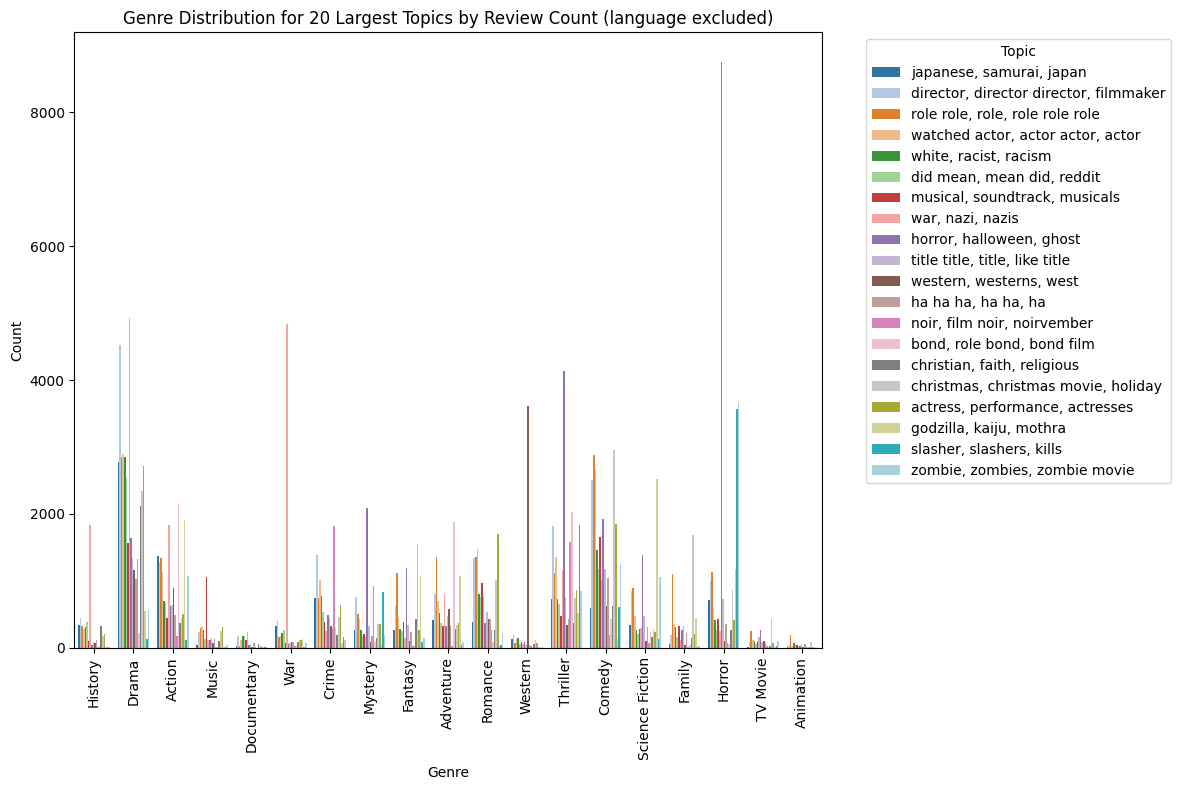

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged_explode[df_merged_explode['topic'].isin(rng)]

# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(), 
                        filtered_df.groupby('topic')['topic_representation'].first().values))

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot
sns.countplot(
    data=filtered_df,
    x='letterboxd_genres',  # Genre column
    hue='topic_representation',  # Topic column
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution for 20 Largest Topics by Review Count (language excluded)')

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_genre_distribution")
plt.show()


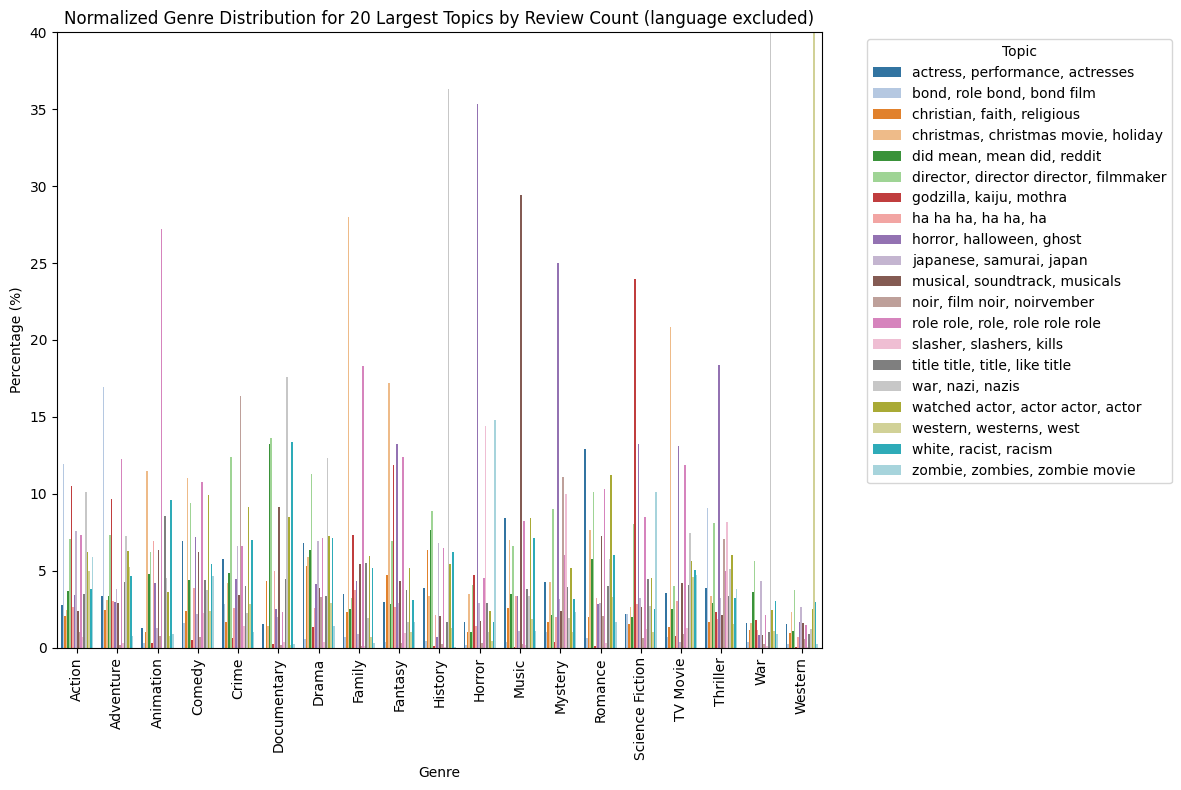

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged_explode[df_merged_explode['topic'].isin(rng)]

# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(), 
                        filtered_df.groupby('topic')['topic_representation'].first().values))


genre_counts = filtered_df.groupby(['letterboxd_genres', 'topic_representation']).size().reset_index(name='count')

# Normalize the counts for each decade
genre_totals = genre_counts.groupby('letterboxd_genres')['count'].transform('sum')
genre_counts['normalized_count'] = genre_counts['count'] / genre_totals * 100  # Normalize to percentage

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot
sns.barplot(
    data=genre_counts,
    x='letterboxd_genres',  # Genre column
    y='normalized_count',
    hue='topic_representation',  # Topic column
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Percentage (%)')
plt.title('Normalized Genre Distribution for 20 Largest Topics by Review Count (language excluded)')
plt.ylim(top=40)
# Show the plot

plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_genre_distribution_normalized")
plt.show()


## More analysis

In [106]:
df_merged['review_dates'] = pd.to_datetime(df_merged['review_dates'], format='%d %b %Y', errors='coerce')
df_merged['review_year'] = df_merged['review_dates'].dt.year
df_merged['review_year'] = pd.to_numeric(df_merged['review_year'], errors='coerce').astype('Int64')
df_merged['review_decade'] = (df_merged['review_year']  // 10) * 10
df_merged['letterboxd_year'] = df_merged['letterboxd_year'].astype(int)
df_merged['release_decade'] = (df_merged['letterboxd_year'] // 10) * 10

In [107]:
df_merged.head(3)

,review,topic,topic_representation,NameIMDB,IMDB_ID,letterboxd_search,url,actors,roles,studio,...,letterboxd_year,letterboxd_rating,letterboxd_genres,IMDB_rating,letter_USD_Budget,letter_US_Gross,letter_WW_Gross,review_year,review_decade,release_decade
0,I am an idiot Why is it that I still dread wat...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],...,1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0,2013,2010,1960
1,honor in the individual is virtuehonor in a so...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],...,1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0,<NA>,<NA>,1960
2,Brilliant Riveting exploration of mortality an...,-1,Outlier,Harakiri,tt0056058,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],...,1962,9.38,"[History, Drama, Action]",8.7,NaN,NaN,15222.0,2024,2020,1960


## Decade topic plots

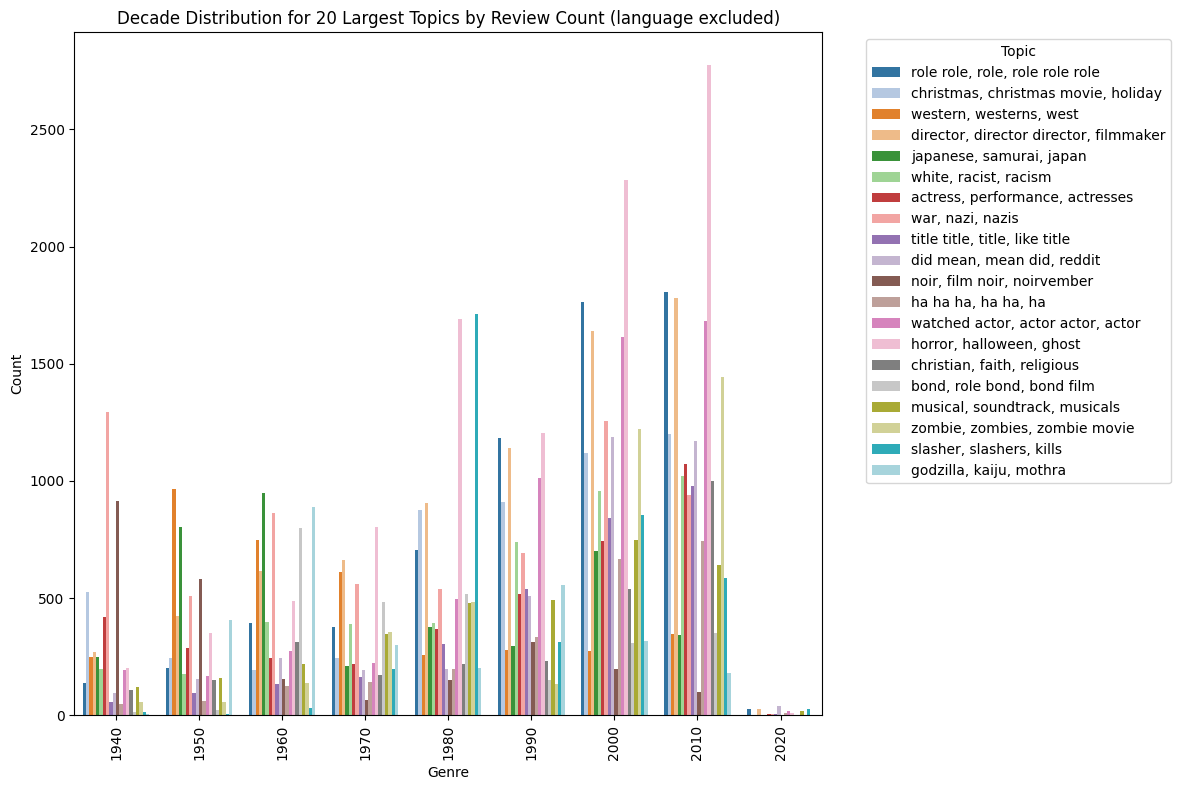

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged[df_merged['topic'].isin(rng)]
filtered_df = filtered_df[filtered_df['release_decade'] > 1930]

# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(), 
                        filtered_df.groupby('topic')['topic_representation'].first().values))

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot
sns.countplot(
    data=filtered_df,
    x='release_decade',  # Genre column
    hue='topic_representation',  # Topic column
    palette='tab20',  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Decade Distribution for 20 Largest Topics by Review Count (language excluded)')

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_decade_distribution")

plt.show()


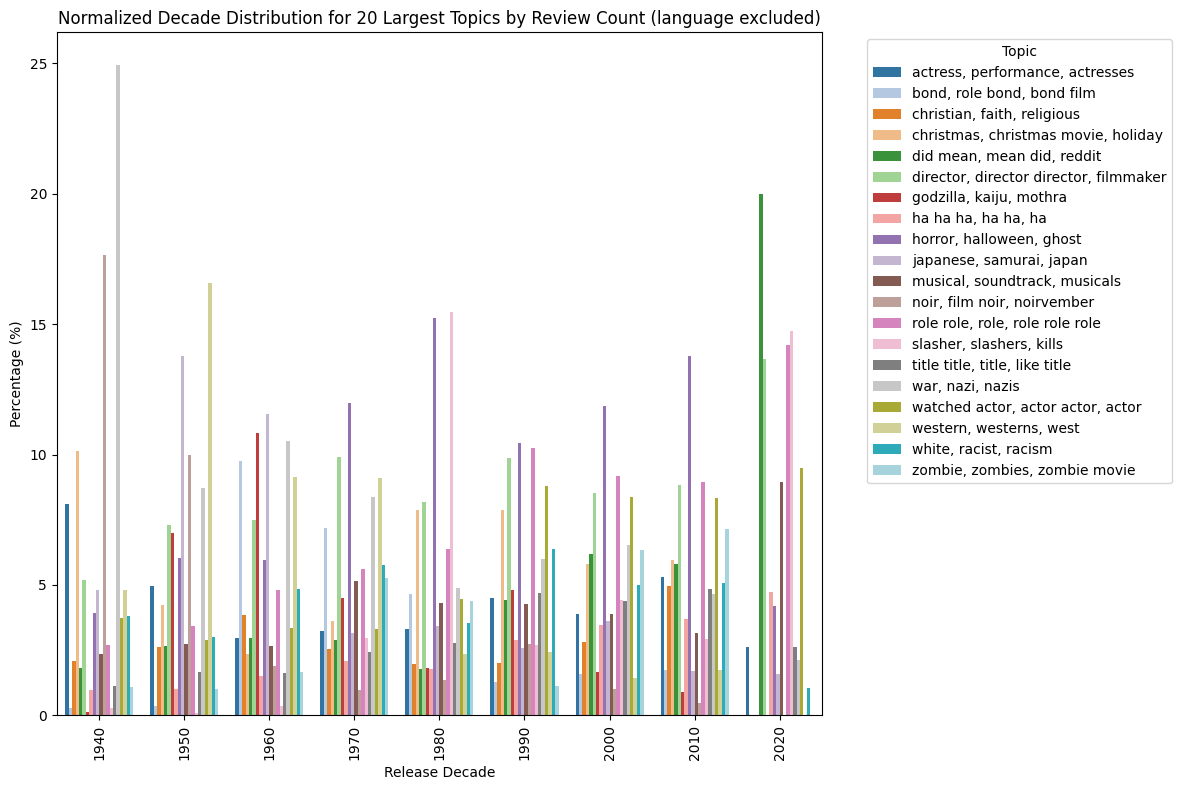

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged[df_merged['topic'].isin(rng)]
filtered_df = filtered_df[filtered_df['release_decade'] > 1930]
# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(), 
                        filtered_df.groupby('topic')['topic_representation'].first().values))

# Group by decade and topic to get counts
decade_counts = filtered_df.groupby(['release_decade', 'topic_representation']).size().reset_index(name='count')

# Normalize the counts for each decade
decade_totals = decade_counts.groupby('release_decade')['count'].transform('sum')
decade_counts['normalized_count'] = decade_counts['count'] / decade_totals * 100  # Normalize to percentage

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot with normalized counts
sns.barplot(
    data=decade_counts,
    x='release_decade',  # Decade column
    y='normalized_count',  # Normalized count column
    hue='topic_representation',  # Topic column
    palette='tab20',  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Release Decade')
plt.ylabel('Percentage (%)')
plt.title('Normalized Decade Distribution for 20 Largest Topics by Review Count (language excluded)')

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_decade_distribution_normalized")

plt.show()


## comment year topic plots

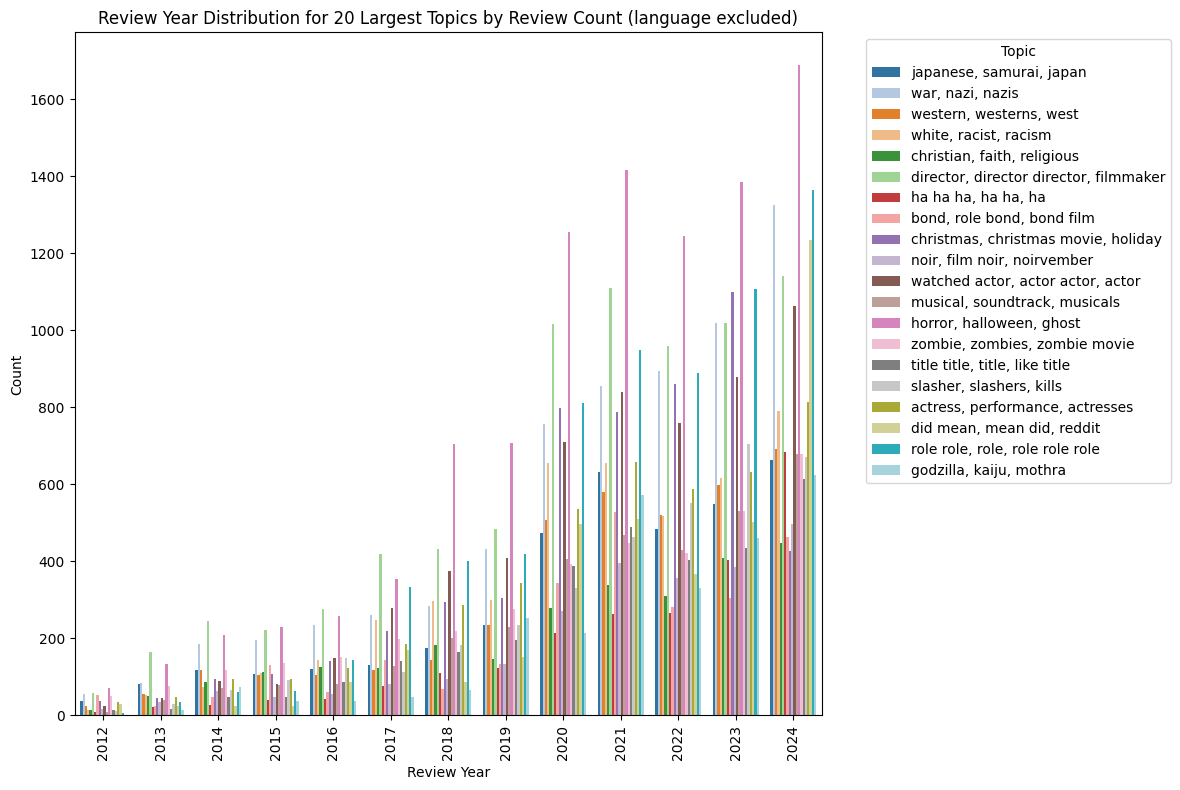

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged[df_merged['topic'].isin(rng)]

# Ensure 'review_year' is numeric and filter for years greater than 2005
filtered_df['review_year'] = pd.to_numeric(filtered_df['review_year'], errors='coerce')

# Filter rows where the year is greater than 2005
filtered_df = filtered_df[filtered_df['review_year'] > 2011]

# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(),
                        filtered_df.groupby('topic')['topic_representation'].first().values))

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot
sns.countplot(
    data=filtered_df,
    x='review_year',  # Review year on x-axis
    hue='topic_representation',  # Topic representation on hue
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Set the labels and title
plt.xlabel('Review Year')
plt.ylabel('Count')
plt.title('Review Year Distribution for 20 Largest Topics by Review Count (language excluded)')

# Set xlim to show years from 2005 onwards
# plt.xlim(filtered_df['review_year'].min(), filtered_df['review_year'].max())

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_commentyear_distribution")

plt.show()


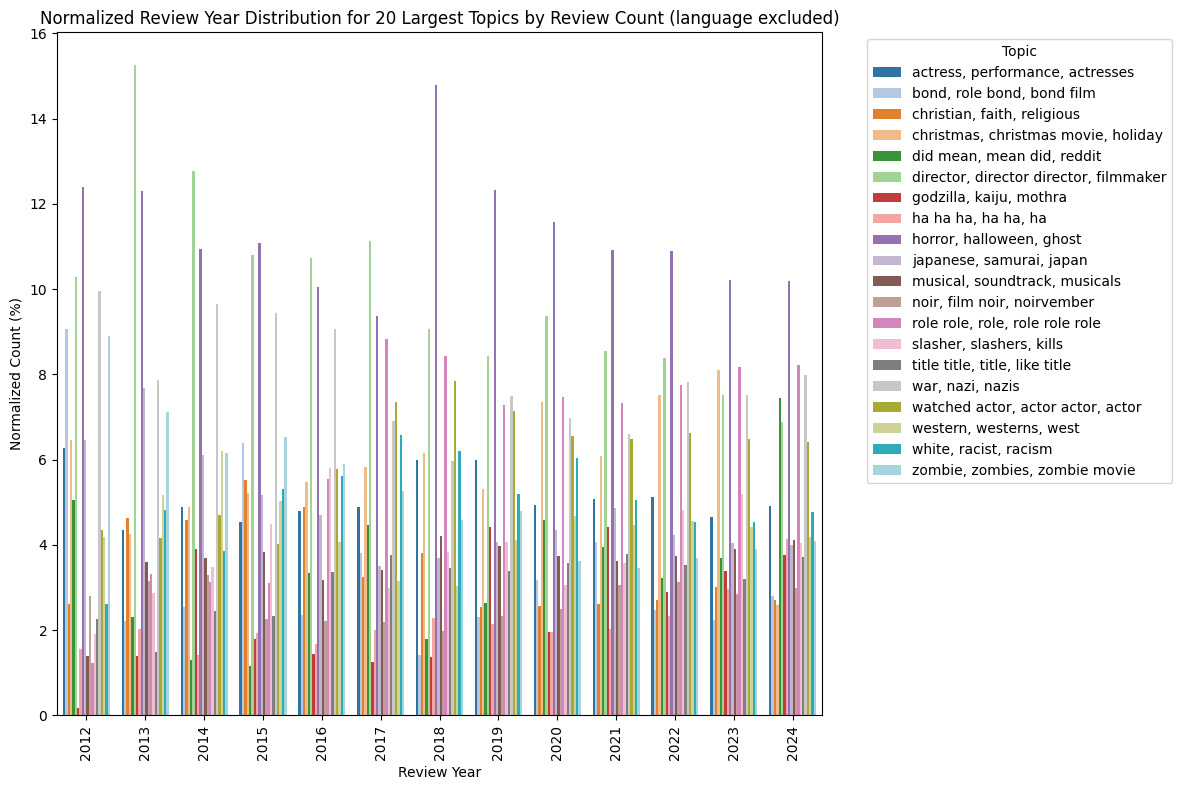

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for topics 1 to 20
rng = range(0, 24)
rng = [i for i in rng if i not in {0, 3, 5, 16}]
filtered_df = df_merged[df_merged['topic'].isin(rng)]

# Ensure 'review_year' is numeric and filter for years greater than 2005
filtered_df['review_year'] = pd.to_numeric(filtered_df['review_year'], errors='coerce')

# Filter rows where the year is greater than 2011
filtered_df = filtered_df[filtered_df['review_year'] > 2011]

# Create a mapping of topics to their representations
topic_mapping = dict(zip(filtered_df['topic'].unique(),
                        filtered_df.groupby('topic')['topic_representation'].first().values))

# Group by year and topic to get counts
year_topic_counts = filtered_df.groupby(['review_year', 'topic_representation']).size().reset_index(name='count')

# Normalize the counts for each year (normalize by year total)
year_totals = year_topic_counts.groupby('review_year')['count'].transform('sum')
year_topic_counts['normalized_count'] = year_topic_counts['count'] / year_totals * 100  # Normalize to percentage

# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot with normalized counts
sns.barplot(
    data=year_topic_counts,
    x='review_year',  # Review year on x-axis
    y='normalized_count',  # Normalized count column
    hue='topic_representation',  # Topic representation on hue
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, title="Topic", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Set the labels and title
plt.xlabel('Review Year')
plt.ylabel('Normalized Count (%)')
plt.title('Normalized Review Year Distribution for 20 Largest Topics by Review Count (language excluded)')

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/topic_commentyear_distribution_normalized")
plt.show()


# Trope Plots

In [112]:
trope_data = pd.read_csv(f"{root}/Data/2020_trope_data/2020_updated_tropeset.csv")

In [113]:
trope_data.head()

,Id,NameTvTropes,NameIMDB,Rating,Votes,Year,ABNegative,ABirthdayNotABreak,ABloodyMess,ABoyAGirlAndABabyFamily,...,[GENRE]Mystery,[GENRE]News,[GENRE]Romance,[GENRE]Sci-Fi,[GENRE]Short,[GENRE]Sport,[GENRE]Thriller,[GENRE]War,[GENRE]Western,[GENRE]\N
0,tt2926810,ABCsOfDeath2,ABCs of Death 2,5.4,7382.0,2014,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt3224458,ABeautifulDayInTheNeighborhood,A Beautiful Day in the Neighborhood,0.0,0.0,2019,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0268978,ABeautifulMind,A Beautiful Mind,8.2,767687.0,2001,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0092263,ABetterTomorrow,A Better Tomorrow,7.6,18562.0,1986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt1582465,ABirdersGuideToEverything,A Birder's Guide to Everything,6.3,1933.0,2013,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
genre_columns = trope_data.filter(like='GENRE', axis=1).columns
genre_columns = genre_columns.tolist() 
movie_columns =[ 'Id', 'NameTvTropes', 'NameIMDB', 'Rating', 'Votes', 'Year']
exclude_columns = genre_columns + movie_columns
tropes = trope_data.drop(columns=exclude_columns).columns
tropes.tolist()

['ABNegative',
 'ABirthdayNotABreak',
 'ABloodyMess',
 'ABoyAGirlAndABabyFamily',
 'ABoyAndHisX',
 'ACappella',
 'ACatInAGangOfDogs',
 'AChatWithSatan',
 'AChildShallLeadThem',
 'AChineseOdyssey',
 'ACrackInTheIce',
 'ACupAngst',
 'ADR',
 'ADarkerMe',
 'ADateWithRosiePalms',
 'ADateWithRosiepalms',
 'ADayAtTheBizarro',
 'ADayInHerApron',
 'ADayInTheLife',
 'ADayInTheLimeLight',
 'ADayInTheLimelight',
 'ADeadlyAffair',
 'ADeathInTheLimelight',
 'ADegreeInUseless',
 'ADickInName',
 'ADogAteMyHomework',
 'ADogNamedDog',
 'ADorkable',
 'AF1',
 'AFIS100Years100HeroesAndVillains',
 'AFIS100Years100MovieQuotes',
 'AFIS100Years100Songs',
 'AFateWorseThanDeath',
 'AFatherToHisMen',
 'AFeteWorseThanDeath',
 'AFistfulOfRehashes',
 'AFoggyDayInLondonTown',
 'AFoolAndHisNewMoneyAreSoonParted',
 'AFoolForAClient',
 'AFormYouAreComfortableWith',
 'AFriendInNeed',
 'AG36',
 'AGirlAndHerX',
 'AGirlInEveryPort',
 'AGlassInTheHand',
 'AGlassOfChianti',
 'AGlitchInTheMatrix',
 'AGodAmI',
 'AGodIAm',
 'AGo

In [115]:
trope_sums = [trope_data[trope].sum() for trope in tropes]
trope_sum_df = pd.DataFrame({
    'trope' : tropes,
    'sum': trope_sums
})
top_tropes = trope_sum_df.sort_values(by='sum', ascending=False)['trope'].iloc[:20].tolist()
trope_data['active_tropes'] = trope_data[tropes].apply(lambda row: [trope for trope in top_tropes if row[trope] == 1], axis=1)


In [116]:
trope_data.drop(columns=tropes, inplace=True)
trope_data.drop(columns=genre_columns, inplace=True)
trope_data.drop(columns= ['Rating', 'Votes', 'Year', 'NameTvTropes'], inplace=True)


In [117]:
df_merged.columns

Index(['review', 'topic', 'topic_representation', 'NameIMDB', 'IMDB_ID',
       'letterboxd_search', 'url', 'actors', 'roles', 'studio', 'review_stars',
       'review_dates', 'letterboxd_directors', 'letterboxd_year',
       'letterboxd_rating', 'letterboxd_genres', 'IMDB_rating',
       'letter_USD_Budget', 'letter_US_Gross', 'letter_WW_Gross',
       'review_year', 'review_decade', 'release_decade'],
      dtype='object')

In [118]:
trope_merged = pd.merge(
    left=trope_data,
    right=df,
    left_on=['Id', 'NameIMDB'],
    right_on=['IMDB_ID', 'NameIMDB'],
    how='right'
)

trope_merged.iloc[:10]

,Id,NameIMDB,active_tropes,letterboxd_search,url,actors,roles,studio,reviews_extracted,review_stars,...,letterboxd_directors,letterboxd_year,letterboxd_rating,letterboxd_genres,IMDB_rating,IMDB_ID,letter_USD_Budget,letter_US_Gross,letter_WW_Gross,NER_cleaned_reviews
0,tt0056058,Harakiri,"[BigBad, BittersweetEnding]",https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],['I am an idiot.Why is it that I still dread w...,"[10, 10, None, 10, 10, 10, None, 9, 10, 10, 9,...",...,['Masaki Kobayashi'],1962,9.38,"[History, Drama, Action]",8.7,tt0056058,NaN,NaN,15222.0,[I am an idiot Why is it that I still dread wa...
1,tt0088178,Stop Making Sense,"[ShoutOut, TitleDrop, LargeHam, RunningGag]",https://letterboxd.com/search/Stop+Making+Sens...,https://letterboxd.com/film/stop-making-sense/,"['David Byrne', 'Chris Frantz', 'Jerry Harriso...","['Self - Vocals, Guitar', 'Self - Drums, Vocal...","['Talking Heads Films', 'Arnold Stiefel Company']",['SAME AS IT EVER WASSAME AS IT EVER WASSAME A...,"[10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10...",...,['Jonathan Demme'],1984,9.36,"[Music, Documentary]",8.5,tt0088178,1200000.0,10306902.0,12471520.0,[SAME AS IT EVER WASSAME AS IT EVER WASSAME AS...
2,tt0091251,Come and See,[Foreshadowing],https://letterboxd.com/search/Come+and+See+1985/,https://letterboxd.com/film/come-and-see/,"['Aleksei Kravchenko', 'Olga Mironova', 'Liubo...","['Flyora Gayshun', 'Glasha', 'Kosach', 'Rubezh...","['Belarusfilm', 'Mosfilm']",['as soon as this film ended i went online and...,"[10, 10, 10, 9, 10, None, 10, 10, 10, 10, 10, ...",...,['Elem Klimov'],1985,9.26,"[War, Drama]",8.2,tt0091251,2500000.0,NaN,20929648.0,[as soon as this film ended i went online and ...
3,tt0047478,Seven Samurai,"[ShoutOut, BittersweetEnding, LargeHam, Driven...",https://letterboxd.com/search/Seven+Samurai+1954/,https://letterboxd.com/film/seven-samurai/,"['Toshirō Mifune', 'Takashi Shimura', 'Yoshio ...","['Kikuchiyo', 'Kambei Shimada', 'Gorobei Katay...",['TOHO'],"['too many sweaty ass cheeks, 5 stars', 'this ...","[10, 9, 10, 10, 8, 10, 10, 9, 10, 10, 10, 10, ...",...,['Akira Kurosawa'],1954,9.22,"[Drama, Action]",8.7,tt0047478,580000.0,NaN,NaN,"[too many sweaty ass cheeks, 5 stars, this is ..."
4,tt0071562,The Godfather: Part II,"[ShoutOut, BigBad, Foreshadowing, OhCrap, Titl...",https://letterboxd.com/search/The+Godfather:+P...,https://letterboxd.com/film/the-godfather-part...,"['Al Pacino', 'Robert Duvall', 'Diane Keaton',...","['Don Michael Corleone', 'Tom Hagen', 'Kay Cor...","['Paramount Pictures', 'The Coppola Company', ...","[""young, totally fuckable al pacino and robert...","[10, 10, 10, None, 10, 8, 9, 8, 10, 10, 8, 7, ...",...,['Francis Ford Coppola'],1974,9.18,"[Crime, Drama]",9.0,tt0071562,13000000.0,47834595.0,47962897.0,"[young, totally fuckable [ACTOR] and [ACTOR] d..."
5,tt0057565,High and Low,[BigBad],https://letterboxd.com/search/High+and+Low+1963/,https://letterboxd.com/film/high-and-low/,"['Toshirō Mifune', 'Tatsuya Nakadai', 'Kyōko K...","['Kingo Gondo', 'Chief Detective Tokura', 'Rei...","['TOHO', 'Kurosawa Production']",['everytime i watch a kurosawa movie i haven’t...,"[10, 9, 9, None, 10, 10, 10, None, 10, 10, 10,...",...,['Akira Kurosawa'],1963,9.18,"[Crime, Drama, Mystery]",8.4,tt0057565,250000.0,NaN,NaN,[everytime i watch a [DIRECTOR] movie i havent...
6,tt0111161,The Shawshank Redemption,"[ShoutOut, BigBad, ChekhovsGun, Foreshadowing,...",https://letterboxd.com/search/The+Shawshank+Re...,https://letterboxd.com/film/the-shawshank-rede...,"['Tim Robbins', 'Morgan Freeman', 'Bob Gunton'...","['Andy Dufresne', ""Ellis Boyd 'Red' Redding"", ...",['Castle Rock Entertainment'],"['If you ever feel down,If you ever feel like ...","[10, 9, 10, 10, 10, 9, 10, 10, 10, None, 7, 8,...",...,['Frank Darabont'],1994,9.12,"[Crime, Drama]",9.3,tt0111161,NaN,NaN,NaN,"[If you ever feel 

In [119]:
trope_merged_explode = trope_merged.explode('active_tropes')
trope_merged_explode = trope_merged_explode.explode('letterboxd_genres')
trope_merged_explode.reset_index(inplace=True)
trope_merged_explode.head(2)


,index,Id,NameIMDB,active_tropes,letterboxd_search,url,actors,roles,studio,reviews_extracted,...,letterboxd_directors,letterboxd_year,letterboxd_rating,letterboxd_genres,IMDB_rating,IMDB_ID,letter_USD_Budget,letter_US_Gross,letter_WW_Gross,NER_cleaned_reviews
0,0,tt0056058,Harakiri,BigBad,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],['I am an idiot.Why is it that I still dread w...,...,['Masaki Kobayashi'],1962,9.38,History,8.7,tt0056058,NaN,NaN,15222.0,[I am an idiot Why is it that I still dread wa...
1,0,tt0056058,Harakiri,BigBad,https://letterboxd.com/search/Harakiri+1962/,https://letterboxd.com/film/harakiri/,"['Tatsuya Nakadai', 'Akira Ishihama', 'Shima I...","['Hanshiro Tsugumo', 'Motome Chijiiwa', 'Miho ...",['Shochiku'],['I am an idiot.Why is it that I still dread w...,...,['Masaki Kobayashi'],1962,9.38,Drama,8.7,tt0056058,NaN,NaN,15222.0,[I am an idiot Why is it that I still dread wa...


## genre trope plots

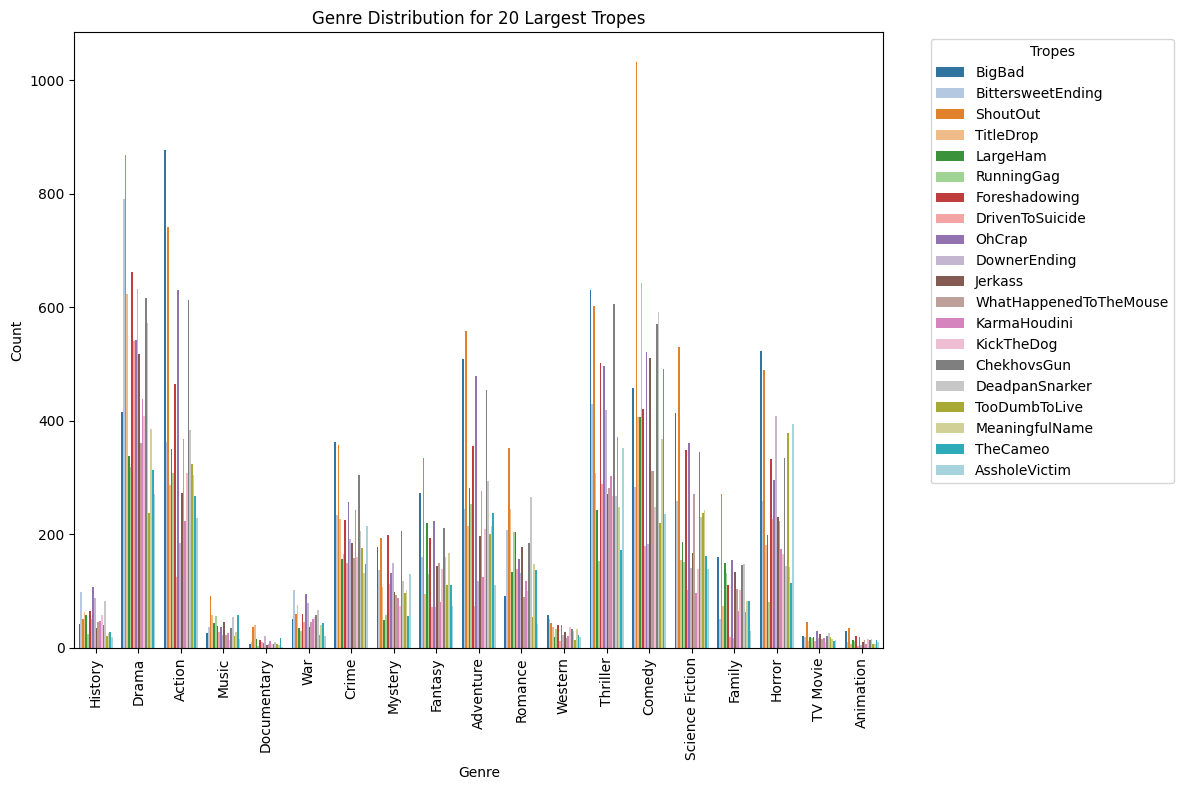

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt



# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

# Create the countplot
sns.countplot(
    data=trope_merged_explode,
    x='letterboxd_genres',  # Genre column
    hue='active_tropes',  # Topic column
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Tropes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Genre Distribution for 20 Largest Tropes')

# Show the plot

plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/trope_genre_distribution")

plt.show()


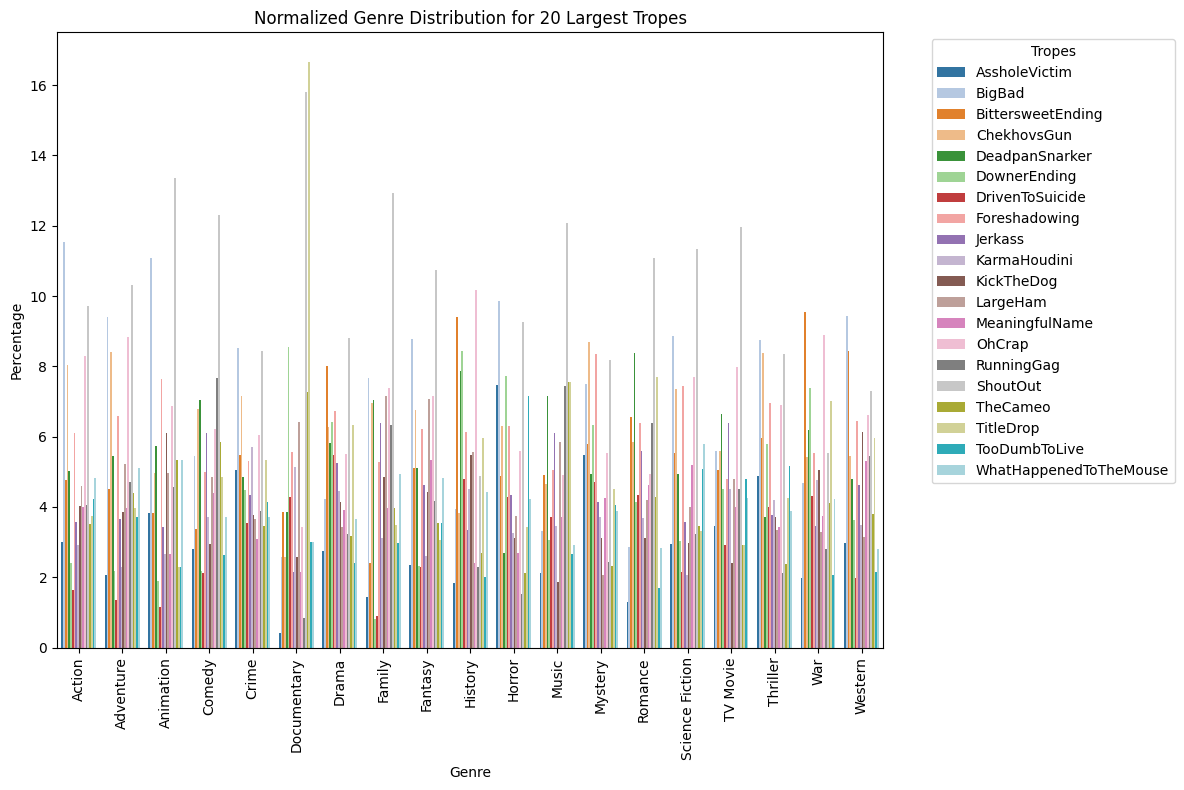

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt



# Create the figure with a larger size (e.g., 12x8 inches)
plt.figure(figsize=(12, 8))  # Adjust the size as needed

genre_counts = trope_merged_explode.groupby(['letterboxd_genres', 'active_tropes']).size().reset_index(name='count')

# Normalize the counts for each decade
genre_totals = genre_counts.groupby('letterboxd_genres')['count'].transform('sum')
genre_counts['normalized_count'] = genre_counts['count'] / genre_totals * 100  # Normalize to percentage


# Create the countplot
sns.barplot(
    data=genre_counts,
    x='letterboxd_genres',  # Genre column
    y='normalized_count',  
    hue='active_tropes', # Topic column
    palette='tab20'  # Color palette
)

# Update the hue labels using the topic mapping (legend)
handles, labels = plt.gca().get_legend_handles_labels()
# new_labels = [topic_mapping[int(label)] for label in labels]  # Replace topic numbers with their representations
plt.legend(handles=handles, title="Tropes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Rotate the x-axis labels for readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.title('Normalized Genre Distribution for 20 Largest Tropes')

# Show the plot

plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/trope_genre_distribution_normalized")

plt.show()


## Trope Size


In [122]:
trope_data = pd.read_csv(f"{root}/Data/2020_trope_data/2020_updated_tropeset.csv")
trope_sums = [trope_data[trope].sum() for trope in tropes]
trope_sum_df = pd.DataFrame({
    'trope' : tropes,
    'sum': trope_sums
})


In [123]:
def df_prob_distributor(df, kcol):
    """
    Given a dataframe with a column of counts kcol, adds Nk and N>k (N_GE_k)
    columns to the dataframe and returns it. This works faster as it's vectorized.
    """

    df['k'] = df[kcol]

    # Calculate Nk and merge it into the count of each sample size in the 'k' column
    dummy = df['k'].value_counts().reset_index()
    dummy.columns = ['k', 'Nk']

    
    #print(dummy['Nk'].duplicated().sum()) # debug
    ## sort by k and to cumsum to get Nk. 
    dummy = dummy.sort_values(by='k', ascending=False)
    dummy['N_GE_k'] = dummy['Nk'].cumsum()
    df = df.merge(dummy, on='k')
    df['Rank'] = df[kcol].rank(ascending=False)

    return df


In [124]:
trope_data_1 = df_prob_distributor(trope_sum_df, 'sum')

In [125]:
trope_data_1.sort_values(by='k', ascending=False).head(10)

,trope,sum,k,Nk,N_GE_k,Rank
19861,ShoutOut,2416,2416,1,1,1.0
2218,BigBad,1769,1769,1,2,2.0
3665,ChekhovsGun,1690,1690,1,3,3.0
8270,Foreshadowing,1536,1536,1,4,4.0
15817,OhCrap,1517,1517,1,5,5.0
2392,BittersweetEnding,1399,1399,1,6,6.0
23636,TitleDrop,1304,1304,1,7,7.0
5188,DeadpanSnarker,1300,1300,1,8,8.0
6074,DownerEnding,1164,1164,1,9,9.0
11952,Jerkass,1158,1158,1,10,10.0


<Axes: xlabel='k', ylabel='Nk'>

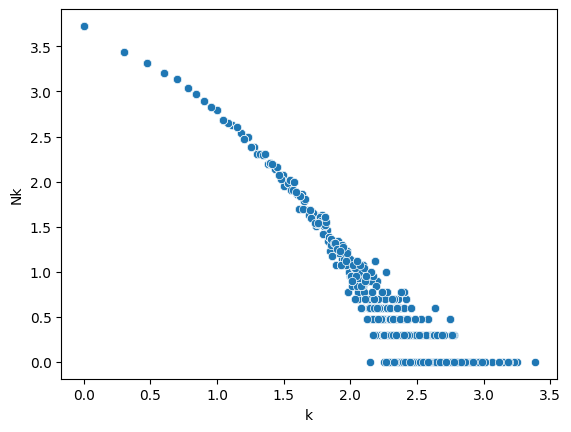

In [126]:
sns.scatterplot(data=trope_data_1[['k', 'Nk']].apply(np.log10), x='k', y='Nk')

<Axes: xlabel='k', ylabel='N_GE_k'>

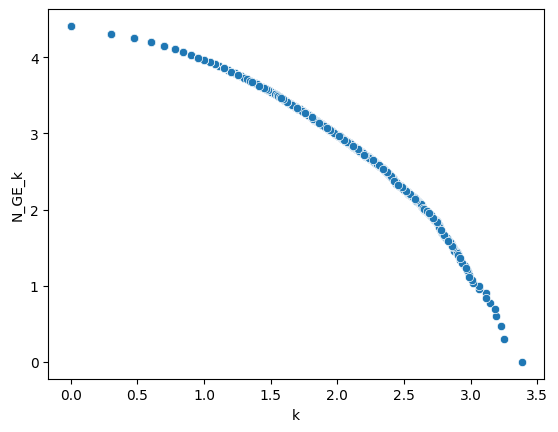

In [127]:
sns.scatterplot(data=trope_data_1[['k', 'N_GE_k']].apply(np.log10), x='k', y='N_GE_k')


<Axes: xlabel='Rank', ylabel='k'>

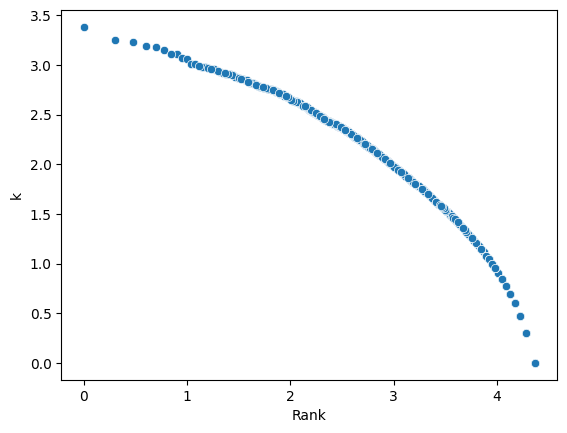

In [128]:
sns.scatterplot(data=trope_data_1[['Rank', 'k']].apply(np.log10), x='Rank', y='k')


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Estimated power-law parameters: alpha=2.300232814510353, xmin=52.0, p_value=4.349855361521741e-05


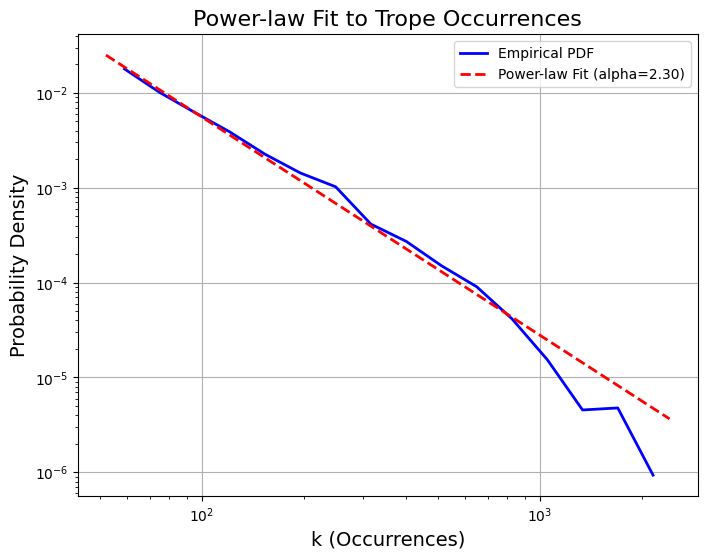

In [129]:
import powerlaw
fit = powerlaw.Fit(trope_data_1['k'])
alpha = fit.alpha
xmin = fit.xmin
R, p_value = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

print(f"Estimated power-law parameters: alpha={alpha}, xmin={xmin}, p_value={p_value}")

# Plotting the distribution and the power-law fit
fig, ax = plt.subplots(figsize=(8, 6))
fit.plot_pdf(color='blue', linewidth=2, label='Empirical PDF', ax=ax)
fit.power_law.plot_pdf(color='red', linestyle='--', linewidth=2, label=f'Power-law Fit (alpha={alpha:.2f})', ax=ax)
ax.set_title('Power-law Fit to Trope Occurrences', fontsize=16)
ax.set_xlabel('k (Occurrences)', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.legend()
plt.grid()

plt.show()

In [130]:
def graph_df(inp_df, X_col, Y_col, logged="", title="", method="scatter", 
             conf_input=None, path=None, bins=None, min_x_val=None, max_x_val=None, save=False,
             grid=True, min_x_plot=None, max_x_plot=None, input_ax=None, show=True,
             min_y_plot=None, max_y_plot=None, y_title=None, x_title=None):
    """
    Homebrew dataframe grapher with different methods, a reasonable combo of seaborn and matplotlib, and options for
    autolabeling and saving.
    
    :param inp_df: the dataframe where you get your data
    :param str X_col: the name of the column which will serve as x-values
    :param str logged: Enter Log_10 to take the log base ten of both x and y values
    :param str method: choose from scatter, reg, bin_scatter, hist, joint
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score

    def fjk_log10(num):
        if num == 0:
            return 0
        else:
            return np.log10(num)

    df_og = inp_df.copy()
    if not y_title: y_title = Y_col
    if not x_title: x_title = X_col

    if bins: bins = int(bins)
    if conf_input: conf_input = float(conf_input)

    if logged.strip() == "Log_10":
        df = inp_df[[X_col, Y_col]].map(fjk_log10)
        df_og = inp_df[[X_col, Y_col]].map(fjk_log10)
    else:
        df = inp_df[[X_col, Y_col]]
        df_og = inp_df[[X_col, Y_col]]

    if min_x_val: df = df[df[X_col] >= float(min_x_val)]
    if max_x_val: df = df[df[X_col] <= float(max_x_val)]

    if not input_ax:
        ax = plt.axes()
        ax.cla()
    else: 
        ax = input_ax

    model = smf.ols(f'{Y_col} ~ {X_col}', data=df).fit()
    slope = model.params.iloc[1]
    intercept = model.params.iloc[0]

    if conf_input:
        confidence_interval = model.conf_int(alpha=(1 - conf_input))
        print(confidence_interval)
        confidence_interval = confidence_interval.iloc[1]
        start_conf = confidence_interval.loc[0]
        end_conf = confidence_interval.loc[1]
        conf_range = end_conf - start_conf

    model_2 = LinearRegression()
    model_2.fit(df[[X_col]], df[[Y_col]])
    alt_slope, alt_intercept = model_2.coef_[0][0], model_2.intercept_[0]

    if logged:
        label_val = f"$ {slope:.3f}\\log(x)+ {intercept:.3f}$"
    else:
        label_val = f" {slope:.3f}x + {intercept:.3f}"

    if conf_input:
        label_val += f" with CI: {start_conf:.3f} to {end_conf:.3f}"

    if method == "reg":
        sns.regplot(data=df, x=X_col, y=Y_col, ci=conf_input, label=label_val, scatter_kws={"s": 25}, line_kws={'color': 'Red'}, ax=ax)
        ax.legend()
    elif method == "reg_alpha":
        alpha = -slope
        label_val = f"alpha = {alpha:.3f} ± {conf_range:.3f}"
        sns.scatterplot(data=df_og, x=X_col, y=Y_col, ax=ax)
        sns.regplot(data=df, x=X_col, y=Y_col, ci=conf_input, label=label_val, scatter=False, line_kws={'color': 'Red'}, ax=ax)
        ax.legend()
    elif method == "reg_gamma":
        gamma = -slope + 1
        label_val = f"gamma = {gamma:.3f} ± {conf_range:.3f}"
        sns.scatterplot(data=df_og, x=X_col, y=Y_col, ax=ax)
        sns.regplot(data=df, x=X_col, y=Y_col, ci=conf_input, label=label_val, scatter=False, line_kws={'color': 'Red'}, ax=ax)
        ax.legend()
    elif method == "bin_scatter": 
        sns.regplot(data=df, x=X_col, y=Y_col, x_bins=int(bins), fit_reg=False, scatter_kws={"s": 5}, ax=ax)
    elif method == "scatter": 
        sns.scatterplot(data=df, x=X_col, y=Y_col, ax=ax, label=label_val)
    elif method == "hist":
        sns.histplot(data=df, x=X_col, y=Y_col, bins=int(bins), ax=ax)
    elif method == "joint":
        sns.jointplot(data=df, x=X_col, y=Y_col, kind="hex", color="#4CB391", ax=ax)
        path = f"{logged}_{title}"
        plt.savefig(path)
        plt.show()
        return
    else:
        raise ValueError(f"Incorrect graphing method. You put in {method}")
        
    ax.set_title(f"{logged}{title}")
    ax.set_ylabel(f"{logged} {y_title}")
    ax.set_xlabel(f"{logged} {x_title}")
    
    if not path: 
        path = f"{logged}{title}"

    if not min_x_plot: min_x_plot = df[X_col].min()
    if not max_x_plot: max_x_plot = df[X_col].max()
    ax.set_xlim(min_x_plot, max_x_plot)

    if not min_y_plot: min_y_plot = df[Y_col].min()
    if not max_y_plot: max_y_plot = df[Y_col].max()
    ax.set_ylim(min_y_plot, max_y_plot)

    if grid: ax.grid()
    if save: plt.savefig(path)
    if show: plt.show()
    return


                  0         1
Intercept  4.348776  4.361393
Rank      -0.799710 -0.795684


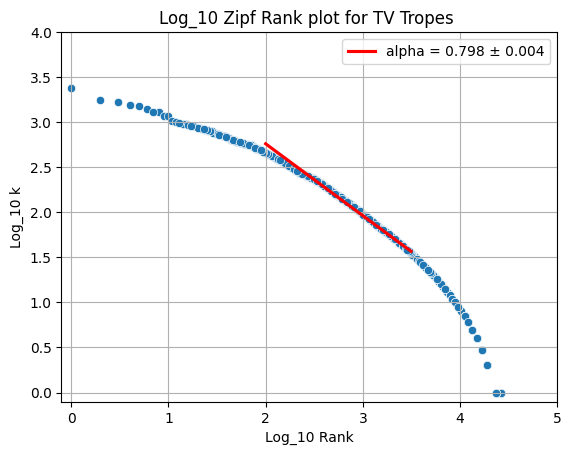

In [131]:
graph_df(trope_data_1, X_col="Rank", Y_col="k", logged="Log_10", 
        title=f" Zipf Rank plot for TV Tropes ", method="reg_alpha", 
        grid=True, 
        min_x_plot=-.1, max_x_plot=5, show=False,
        min_y_plot =-.1, max_y_plot=4, conf_input=.95,
        min_x_val=2, max_x_val=3.5,
        save=True, path=f"{root}/Figures/Main/Zipf_Rank_Tv_Tropes")

Calculating best minimal value for power law fit
Estimated power-law parameters: alpha=2.085760159651168, xmin=1104.0, p_value=0.0


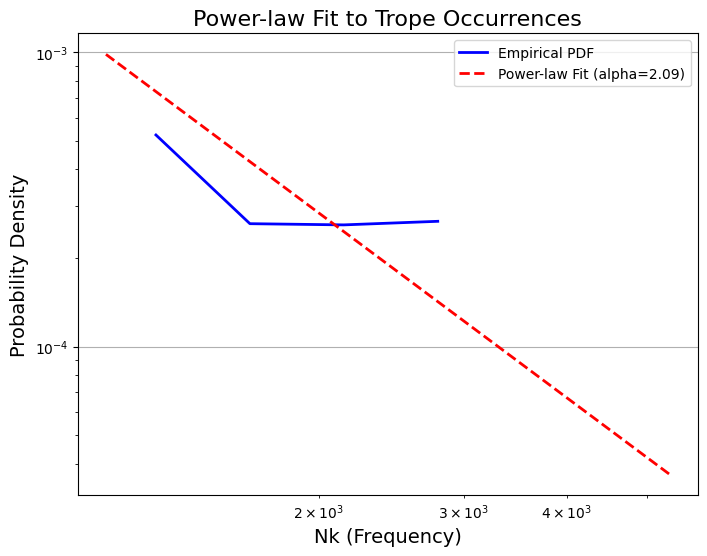

In [132]:
import powerlaw
fit = powerlaw.Fit(trope_data_1['Nk'])
alpha = fit.alpha
xmin = fit.xmin
R, p_value = fit.distribution_compare('power_law', 'lognormal', normalized_ratio=True)

print(f"Estimated power-law parameters: alpha={alpha}, xmin={xmin}, p_value={p_value}")

# Plotting the distribution and the power-law fit
fig, ax = plt.subplots(figsize=(8, 6))
fit.plot_pdf(color='blue', linewidth=2, label='Empirical PDF', ax=ax)
fit.power_law.plot_pdf(color='red', linestyle='--', linewidth=2, label=f'Power-law Fit (alpha={alpha:.2f})', ax=ax)
ax.set_title('Power-law Fit to Trope Occurrences', fontsize=16)
ax.set_xlabel('Nk (Frequency)', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.legend()
plt.grid()

plt.show()

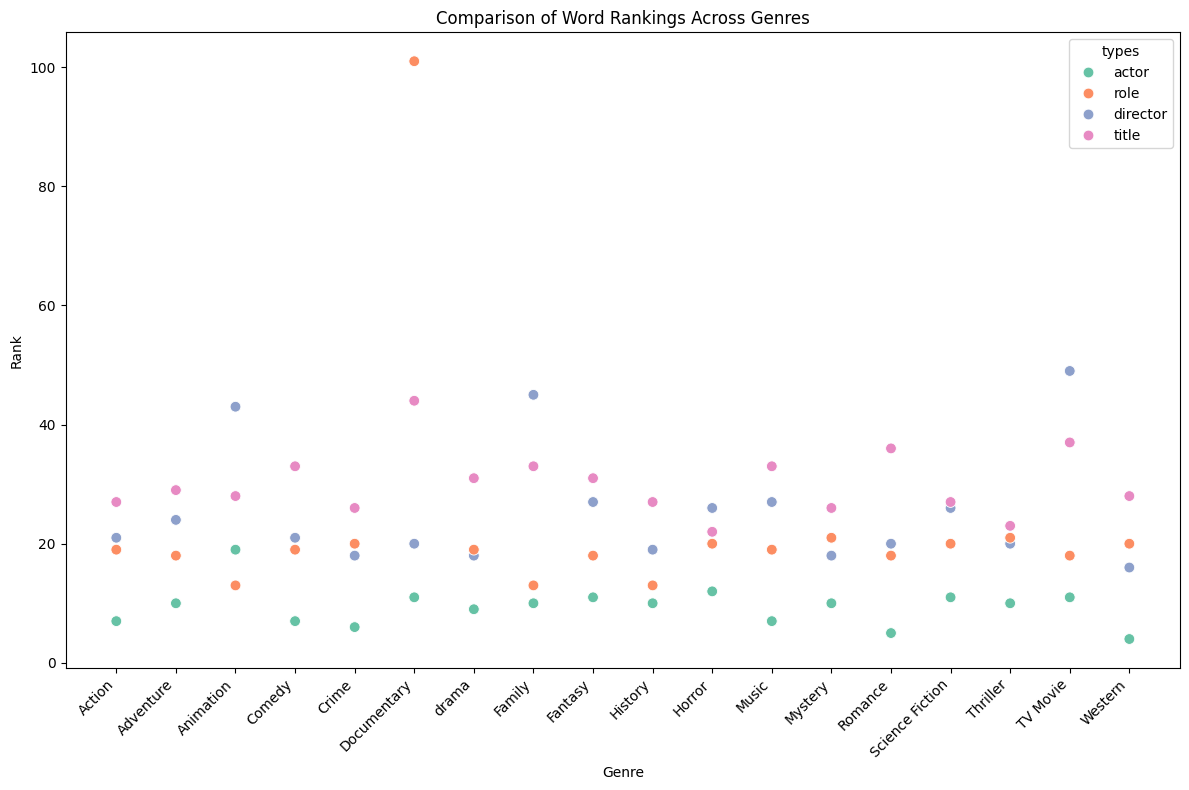

In [152]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Folder path containing the CSV files
folder_path = f"{root}/Data/Subset_Data_NER/Unigrams/genre_freq/"

# Initialize an empty list to hold the data for each genre
all_data = []

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # Extract the genre from the first part of the file name (before the first underscore)
        genre = filename.split('_')[0]

        # Read the CSV file
        df = pd.read_csv(os.path.join(folder_path, filename))

        # Process the DataFrame: rename the index and reset
        df = df.rename_axis("rank", axis="index").reset_index()

        # Filter by the 'types' column
        df = df[df['types'].isin(['actor', 'role', 'director', 'title'])]

        # Add the genre as a new column
        df['genre'] = genre

        # Append the processed data for this genre to the list
        all_data.append(df)

# Combine all the data frames into one
combined_data = pd.concat(all_data, ignore_index=True)

# Now, we can plot the comparison of rankings for different words across genres
plt.figure(figsize=(12, 8))

# Create a seaborn boxplot or violin plot to compare rankings
sns.scatterplot(x='genre', y='rank', hue='types', data=combined_data, palette='Set2', s=60)

# Add labels and title
plt.title('Comparison of Word Rankings Across Genres')
plt.xlabel('Genre')
plt.ylabel('Rank')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.savefig(f"{root}/Figures/Main/keyword_rankings_by_genre")
plt.show()
